In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/df_requests_x_y.csv")
len(df)

860982

In [3]:
df

,x,y
0,solicitação processo administrativo cadastrar ...,MF - Ministério da Fazenda
1,prezar senhor enviar processo acima foto menci...,ANTT – Agência Nacional de Transportes Terrestres
2,presidente associação projeto ação comunitário...,MDS - Ministério do Desenvolvimento e Assistên...
3,ver cópia termo acusação relatório processo,CVM – Comissão de Valores Mobiliários
4,dia nome andré pievir período curso ciência bi...,"IFPE – Instituto Federal de Educação, Ciência ..."
...,...,...
860977,solicitar gentileza informar situação defesa a...,PRF – Polícia Rodoviária Federal
860978,solicitar taxa evasão taxo reprovação discipli...,"IFSULDEMINAS – Instituto Federal de Educação, ..."
860979,solicitar reposta reclamação abrir protocolo c...,ECT – Empresa Brasileira de Correios e Telégrafos
860980,íntegra seguinte processo fiscalização ccc inc...,ANEEL – Agência Nacional de Energia Elétrica


In [4]:
train_length = int(0.8 * len(df))
validation_length = int(0.1 * len(df))

df_train = df.iloc[:train_length].copy()
df_val = df.iloc[train_length : train_length + validation_length].copy()
df_test = df.iloc[train_length + validation_length :].copy()

df_train.shape, df_val.shape, df_test.shape

((688785, 2), (86098, 2), (86099, 2))

### TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer with specific parameters:
# - max_features: limit the number of features to 1000
# - ngram_range: consider unigrams and bigrams
# - min_df: ignore terms that appear in fewer than 5 documents
# - max_df: ignore terms that appear in more than 80% of documents
# - lowercase: convert all text to lowercase
vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    lowercase=True,
)

# Transform the text data into TF-IDF vectors
# This converts the text data into numerical form suitable for machine learning models
X_train = vectorizer.fit_transform(df_train["x"])
X_val = vectorizer.transform(df_val["x"])
X_test = vectorizer.transform(df_test["x"])

In [18]:
from joblib import dump

dump(vectorizer, "../models/lai_ms_tfidf_vectorizer.joblib")

['../models/lai_ms_tfidf_vectorizer.joblib']

In [19]:
vectorizer_out = X_train
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

In [20]:
import numpy as np


def get_top_ngrams(
    X_train: np.ndarray, vectorizer: TfidfVectorizer, top_n: int = 30
) -> np.ndarray:
    """
    Get the top n most frequent n-grams from the vectorized text data.

    Sum all the columns to get the total frequency of each n-gram.
    Sort the n-grams by their total frequency.
    Get the indices of the top n most frequent n-grams.
    Get the names of the n-grams.
    Returns the names of the n-grams corresponding to the top n indices.

    Args:
        X_train (np.ndarray): The vectorized text data.
        vectorizer (TfidfVectorizer): The vectorizer used to transform the text data.
        top_n (int, optional): The number of top n-grams to return. Defaults to 30.

    Returns:
        np.ndarray: An array of the top n most frequent n-grams.
    """
    total_ngram_frequencies = np.sum(X_train, axis=0)

    sorted_ngrams_indices = np.argsort(total_ngram_frequencies)[::-1]

    top_ngrams_indices = sorted_ngrams_indices[:top_n]

    ngram_names = np.array(vectorizer.get_feature_names_out())

    return ngram_names[top_ngrams_indices]


top_ngrams = get_top_ngrams(X_train, vectorizer, top_n=30)
top_ngrams

array(['gostar', 'solicitar', 'informação', 'processo', 'ano', 'acesso',
       'dia', 'prezar', 'cópia', 'contrato', 'documento', 'dar', 'cargo',
       'empresa', 'federal', 'lei', 'caso', 'anexo', 'receber', 'público',
       'solicito', 'agradeço', 'nome', 'referente', 'realizar', 'preciso',
       'instituição', 'informar', 'brasil', 'pedir'], dtype=object)

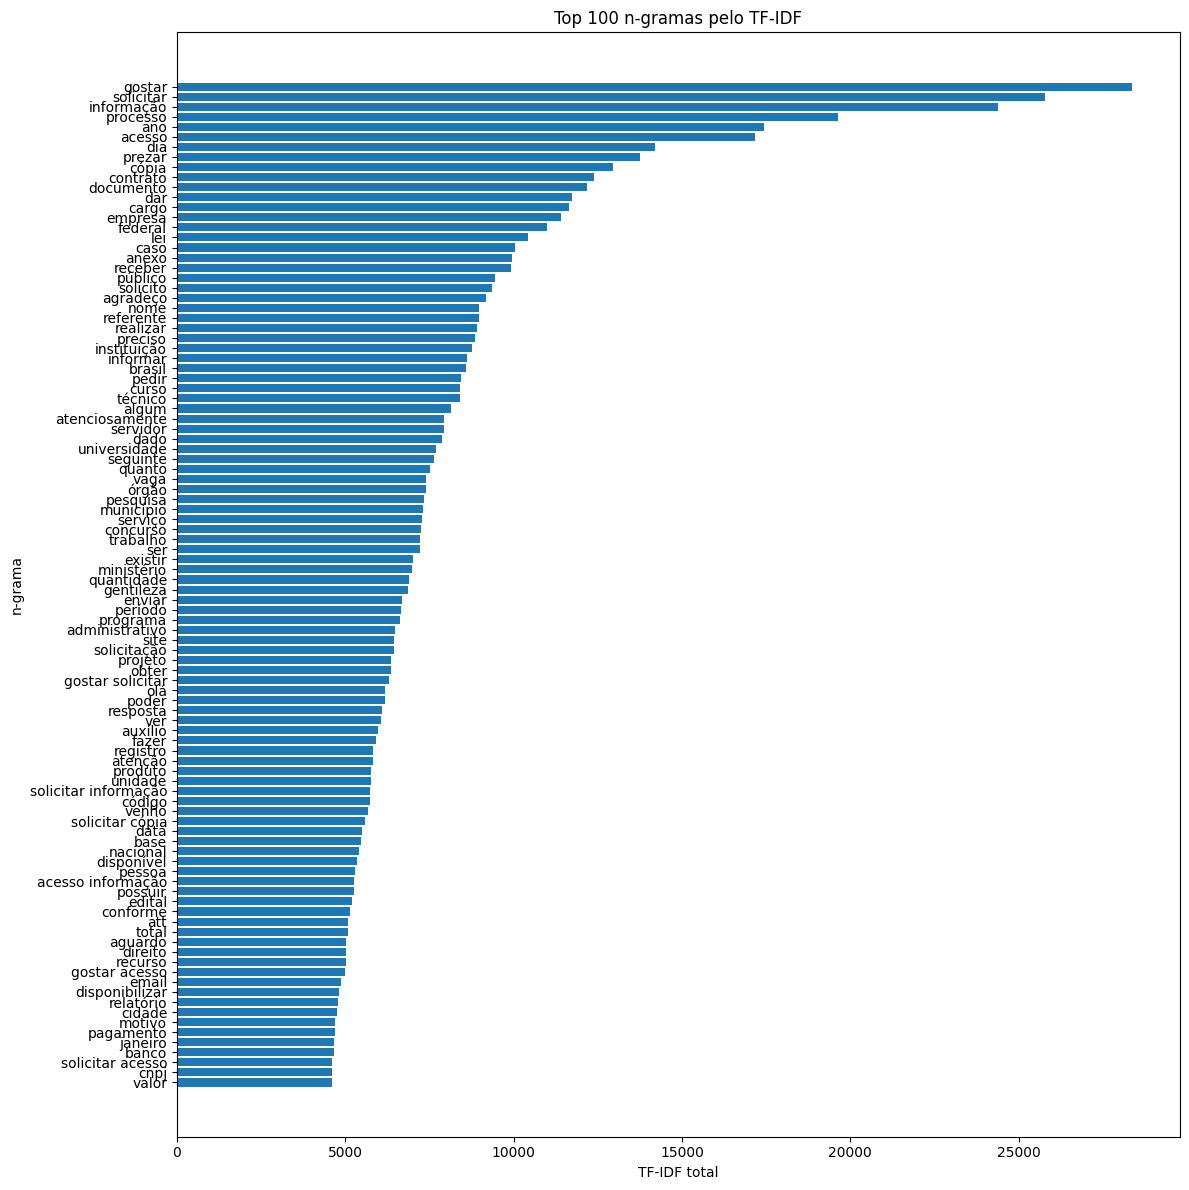

In [21]:
import matplotlib.pyplot as plt

tfidf_sum = vectorizer_out.sum(axis=0).A1

# DataFrame com termos e valores
terms = vectorizer.get_feature_names_out()
df = pd.DataFrame({'ngram': terms, 'tfidf': tfidf_sum})

# Top K
top_k = 100
df_top = df.sort_values("tfidf", ascending=False).head(top_k)

# Plot
plt.figure(figsize=(12,12))
plt.barh(df_top['ngram'], df_top['tfidf'])
plt.gca().invert_yaxis()  # deixa o maior em cima
plt.title(f"Top {top_k} n-gramas pelo TF-IDF")
plt.xlabel("TF-IDF total")
plt.ylabel("n-grama")
plt.tight_layout()
plt.show()

In [22]:
import numpy as np

np.savez(
    "../data/train.npz",
    X=X_train,
    y=df_train["y"].values
)

In [23]:
np.savez(
    "../data/val.npz",
    X=X_val,
    y=df_val["y"].values
)

In [24]:
np.savez(
    "../data/test.npz",
    X=X_test,
    y=df_test["y"].values
)